<a href="https://colab.research.google.com/github/Vincent-SS/sig-worldwide-traders/blob/main/newalgo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math
plt.style.use('fivethirtyeight')

In [2]:
# Load & Store the data
#SPY
url = 'https://query1.finance.yahoo.com/v7/finance/download/SPY?period1=1483228800&period2=1601424000&interval=1d&events=history&includeAdjustedClose=true'

#QQQ
#url = 'https://query1.finance.yahoo.com/v7/finance/download/QQQ?period1=1483228800&period2=1601424000&interval=1d&events=history&includeAdjustedClose=true'

#XLE
#url = 'https://query1.finance.yahoo.com/v7/finance/download/XLE?period1=1483228800&period2=1601424000&interval=1d&events=history&includeAdjustedClose=true'

ETF = pd.read_csv(url)
ETF

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,225.039993,225.830002,223.880005,225.240005,209.785889,91366500
1,2017-01-04,225.619995,226.750000,225.610001,226.580002,211.033981,78744400
2,2017-01-05,226.270004,226.580002,225.479996,226.399994,210.866318,78379000
3,2017-01-06,226.529999,227.750000,225.899994,227.210007,211.620728,71559900
4,2017-01-09,226.910004,227.070007,226.419998,226.460007,210.922211,46939700
...,...,...,...,...,...,...,...
937,2020-09-23,330.899994,331.200012,322.100006,322.640015,322.640015,93112200
938,2020-09-24,321.220001,326.799988,319.799988,323.500000,323.500000,76681300
939,2020-09-25,322.579987,329.579987,321.640015,328.730011,328.730011,71069400
940,2020-09-28,333.220001,334.959991,332.149994,334.190002,334.190002,64584600


In [3]:
# Calculate the typical price ( TP, formula: TP = (H+L+C)/3 )
TP = pd.DataFrame()
TP['Typical Price'] = (ETF['High'] + ETF['Low'] + ETF['Adj Close']) / 3
TP['TWAP TP'] = (ETF['Open'] + ETF['High'] + ETF['Low'] + ETF['Close']) / 4
TP

,Typical Price,TWAP TP
0,219.831965,224.997501
1,221.131327,226.140000
2,220.975439,226.182499
3,221.756907,226.847500
4,221.470739,226.715004
...,...,...
937,325.313344,326.710007
938,323.366659,322.829994
939,326.650004,325.632500
940,333.766662,333.629997


In [4]:
# Calculate VWAP (formula: VWAP = cumulative TP * v / cumulative volume)
VWAP = pd.DataFrame()
TPV = TP['Typical Price'] * ETF['Volume']

TPVcum = TPV.rolling(10).sum()
Vcum = ETF['Volume'].rolling(10).sum()

VWAP['MVWAP'] = TPVcum / Vcum

VWAP

TWAP = pd.DataFrame()
TWAP['TWAP'] = TP['TWAP TP'].rolling(10).mean()

TWAP

,TWAP
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
937,333.918751
938,332.424499
939,331.541499
940,331.140749


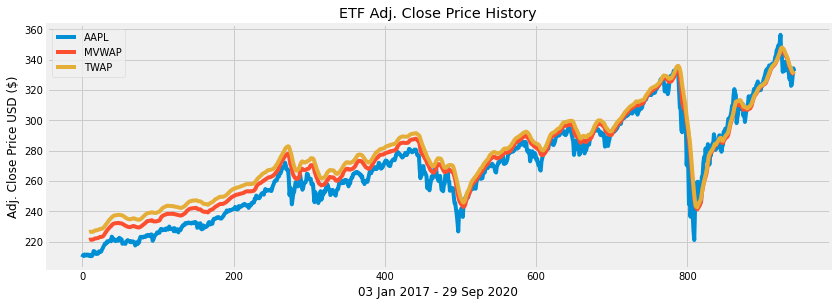

In [5]:
# Visualize the data
plt.figure(figsize=(12.5, 4.5))
plt.plot(ETF['Adj Close'], label = 'AAPL')
plt.plot(VWAP['MVWAP'], label = 'MVWAP')
plt.plot(TWAP['TWAP'], label = 'TWAP')
plt.title('ETF Adj. Close Price History')
plt.xlabel('03 Jan 2017 - 29 Sep 2020')
plt.ylabel('Adj. Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()

In [6]:
SMA30 = pd.DataFrame()
SMA30['Adj Close'] = ETF['Adj Close'].rolling(window = 10).mean()
SMA30

,Adj Close
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
937,332.374127
938,331.468250
939,331.068442
940,330.776389


In [7]:
SMA100 = pd.DataFrame()
SMA100['Adj Close'] = ETF['Adj Close'].rolling(window = 30).mean()
SMA100

,Adj Close
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
937,338.438113
938,338.018292
939,337.793058
940,337.749491


In [8]:
# Create a funciton to signal when to buy and sell the asset/stock/ETF
def buy_sell(data):
    sigPriceBuy = []
    sigPriceSell = []
    flag = -1
    shares_trans = 3000 # how many shares buy/sell in each transaction
    capital = 1000000 #starting capital of 1 million
    shares_traded = 0
    shares_owned = 0

    #TODO: specify how many shares to buy/purchase (maybe change based off how much we predict the price will change)

    for i in range(len(data)):
        # execute the buy/sell when the means cross ONLY if the price is within $x of the vwap <- change the value
        if data['SMA30'][i] > data['SMA100'][i] and data['ETF'][i]-data['VWAP'][i] <= 1:
            if flag != 1:
                sigPriceBuy.append(data['ETF'][i])               
                sigPriceSell.append(np.nan)
                flag = 1

                print("buy " + str(data['ETF'][i]))
                shares_owned += shares_trans
                shares_traded += shares_trans
                capital -= shares_trans*data['ETF'][i]
                # buy 0.003% of the market volume unless it goes over our cap.
                #shares_trans = math.floor(ETF['Volume'][i] * 0.00003)
                #if shares_trans >= 2500:
                #    shares_trans = 2500
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        elif data['SMA30'][i] < data['SMA100'][i] and data['VWAP'][i]-data['ETF'][i] <= 1:
            if flag != 0 and sigPriceBuy:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data['ETF'][i])
                flag = 0

                print("sell " + str(data['ETF'][i]))
                shares_owned -= shares_trans
                capital += shares_trans*data['ETF'][i]
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        else:
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
    return (sigPriceBuy, sigPriceSell, capital, shares_owned, shares_traded)

In [9]:
data = pd.DataFrame()
data['ETF'] = ETF['Adj Close']
data['SMA30'] = SMA30['Adj Close']
data['SMA100'] = SMA100['Adj Close']
data['VWAP'] = VWAP['MVWAP']
data['TWAP'] = TWAP['TWAP']
data

# Store the buy and sell data into a variable
buy_sell = buy_sell(data)
data['Buy_Signal_Price'] = buy_sell[0]
data['Sell_Signal_Price'] = buy_sell[1]

print()

# calculating profits
print("Starting Capital = 1000000")
print("Ending Capital = " + str(buy_sell[2]))
print("Shares owned = " + str(buy_sell[3]))
print("Shares traded = " + str(buy_sell[4]))

print("ETF current trading price: " + str(ETF['Adj Close'].tail(1).item()))
net_value = buy_sell[2] + buy_sell[3]*ETF['Adj Close'].tail(1).item()
print("Net value = " + str(net_value))

total_profit = net_value - 1000000
print("Total profit = " + str(total_profit))

returns = total_profit/1000000 * 100
print("Return on investment: " + str(returns) +'%')

data

buy 217.665451
sell 264.641724
buy 263.304688
sell 268.66247599999997
buy 252.50624100000002
sell 276.766571
buy 281.100769
sell 285.465851
buy 291.129669
sell 290.65918
buy 293.337402
sell 308.433655
buy 270.759888
sell 334.190002

Starting Capital = 1000000
Ending Capital = 1477046.053
Shares owned = 0
Shares traded = 21000
ETF current trading price: 332.369995
Net value = 1477046.053
Total profit = 477046.0530000001
Return on investment: 47.70460530000001%


,ETF,SMA30,SMA100,VWAP,TWAP,Buy_Signal_Price,Sell_Signal_Price
0,209.785889,NaN,NaN,NaN,NaN,NaN,NaN
1,211.033981,NaN,NaN,NaN,NaN,NaN,NaN
2,210.866318,NaN,NaN,NaN,NaN,NaN,NaN
3,211.620728,NaN,NaN,NaN,NaN,NaN,NaN
4,210.922211,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
937,322.640015,332.374127,338.438113,332.737019,333.918751,NaN,NaN
938,323.500000,331.468250,338.018292,331.495897,332.424499,NaN,NaN
939,328.730011,331.068442,337.793058,330.847859,331.541499,NaN,NaN
940,334.190002,330.776389,337.749491,330.559888,331.140749,NaN,334.190002


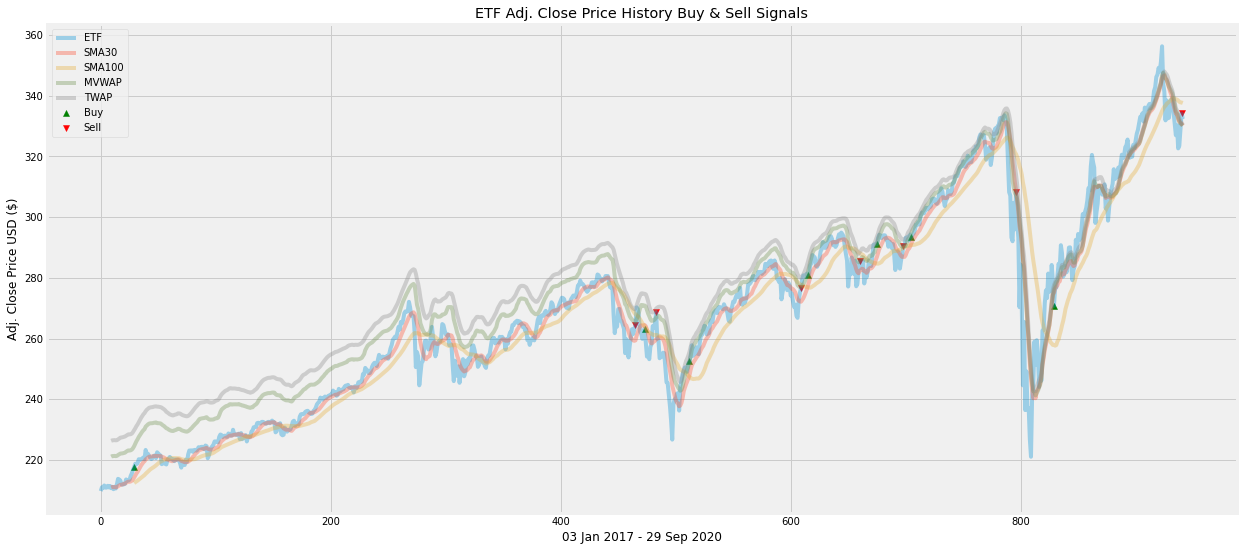

In [10]:
# Visualize the data and the strategy to buy and sell the stock/ETF
plt.figure(figsize=(19, 9))
plt.plot(data['ETF'], label = 'ETF', alpha = 0.35)
plt.plot(data['SMA30'], label = 'SMA30', alpha = 0.35)
plt.plot(data['SMA100'], label = 'SMA100', alpha = 0.35)
plt.plot(data['VWAP'], label = 'MVWAP', alpha = 0.35)
plt.plot(data['TWAP'], label = 'TWAP', alpha = 0.35)
plt.scatter(data.index, data['Buy_Signal_Price'], label = 'Buy', marker = '^', color = 'green')
plt.scatter(data.index, data['Sell_Signal_Price'], label = 'Sell', marker = 'v', color = 'red')
plt.title('ETF Adj. Close Price History Buy & Sell Signals')
plt.xlabel('03 Jan 2017 - 29 Sep 2020')
plt.ylabel('Adj. Close Price USD ($)')
plt.legend(loc = 'upper left')
plt.show()